<a href="https://colab.research.google.com/github/BishalBiswal/Improved-brain-tumour-classification-using-ViT/blob/main/fT_ViT_B16bnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch [1/20], Loss: 0.6595, Accuracy: 0.7728
Validation Loss: 0.4403, Accuracy: 0.9298
Epoch [2/20], Loss: 0.4823, Accuracy: 0.8738
Validation Loss: 0.3961, Accuracy: 0.9443
Epoch [3/20], Loss: 0.4537, Accuracy: 0.8986
Validation Loss: 0.3748, Accuracy: 0.9420
Epoch [4/20], Loss: 0.4335, Accuracy: 0.9088
Validation Loss: 0.3220, Accuracy: 0.9733
Epoch [5/20], Loss: 0.4156, Accuracy: 0.9186
Validation Loss: 0.2958, Accuracy: 0.9794
Epoch [6/20], Loss: 0.4078, Accuracy: 0.9196
Validation Loss: 0.2996, Accuracy: 0.9825
Epoch [7/20], Loss: 0.4039, Accuracy: 0.9247
Validation Loss: 0.2971, Accuracy: 0.9825
Epoch [8/20], Loss: 0.4002, Accuracy: 0.9296
Validation Loss: 0.3172, Accuracy: 0.9725
Epoch [9/20], Loss: 0.3893, Accuracy: 0.9287
Validation Loss: 0.2882, Accuracy: 0.9794
Epoch [10/20], Loss: 0.3847, Accuracy: 0.9389
Validation Loss: 0.2804, Accuracy: 0.9893
Epoch [11/20], Loss: 0.3834, Accuracy: 0.9331
Validation Loss: 0.2855, Accuracy: 0.9863
Epoch [12/20], Loss: 0.3787, Accuracy: 0.

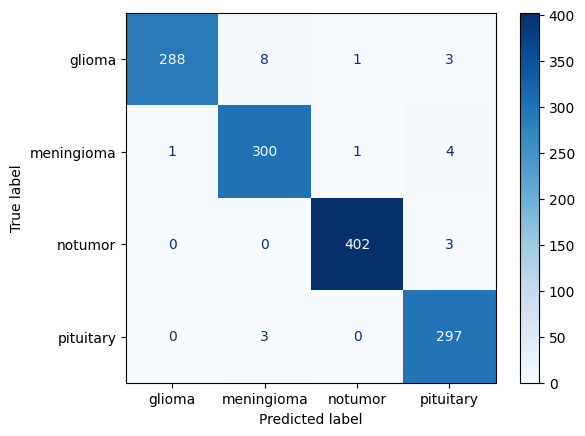

Validation Accuracy: 0.9817
Precision: 0.9820
Recall: 0.9817
F1 Score: 0.9817


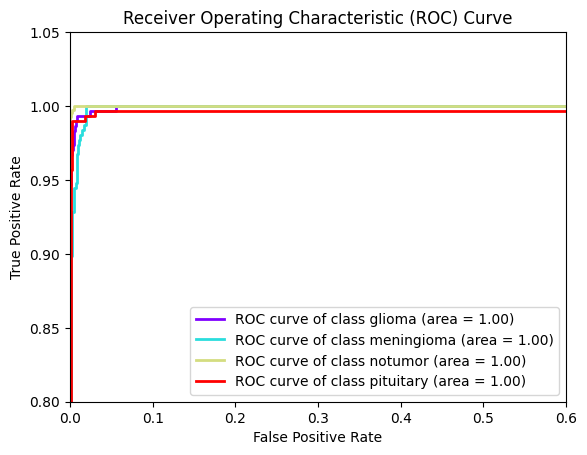

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from torchvision.models import vit_b_16, ViT_B_16_Weights
import numpy as np
from sklearn.preprocessing import label_binarize

# Define data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Add color jittering
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.8, 1.2)),  # Random resized crop
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective transformation
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
data_dir = '/content/drive/MyDrive/archive(1)'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Testing'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained ViT model and fine-tune it for your number of classes
model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
# Access the last layer in the heads object
model.heads[-1] = nn.Linear(model.heads[-1].in_features, len(train_dataset.classes))  # Adjust the final layer

# Define dropout
dropout = nn.Dropout(0.2)
# Define batch normalization
batch_norm = nn.BatchNorm1d(len(train_dataset.classes))

# Combine the layers
model.heads = nn.Sequential(
    model.heads,
    batch_norm,
    dropout
)

# Move the model to the GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
batch_norm = batch_norm.to(device)  # Ensure batch_norm is on the same device

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 20
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait if validation loss doesn't improve
counter = 0  # Counter to track the number of epochs with no improvement

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1

        if counter >= patience:
            print("Early stopping triggered. No improvement in validation loss.")
            break

print("Training complete.")

# Compute and plot confusion matrix
model.eval()
y_true = []
y_pred = []
y_score = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Compute accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Compute and plot ROC curve and AUC for each class
y_score = np.array(y_score)
n_classes = len(train_dataset.classes)

# Binarize the output
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(train_dataset.classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 0.6])
plt.ylim([0.8, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
